# Inference Using Tuned Mask R-CNN

Use Mask R-CNN tuned on the WAD to perform inference.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 

ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

from wad_config import WadConfig
from wad_dataset import WadDataset
from wad_dataset_val import WadDatasetVal

print("Making config")
config = WadConfig()
inference_config=config
print("Creating Inference Model")
model = modellib.MaskRCNN(mode="inference",config=inference_config, model_dir=MODEL_DIR)

print(MODEL_DIR)

# assumes that the weights are in the mrcnn/logs folder

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = model.find_last()[1]
print("Loading weights")
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Making config
Creating Inference Model
/home/stevenzc/Mask_RCNN/mrcnn/logs
Loading weights
Loading weights from  /home/stevenzc/Mask_RCNN/mrcnn/logs/wad20180517T2126/mask_rcnn_wad_0200.h5


In [2]:
# Our WAD Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'car', 'motorcycle', 'bicycle', 'person', 'truck', 'bus', 'tricycle']

print('car', class_names.index('car'))
print('motorcycle', class_names.index('motorcycle'))
print('bicycle', class_names.index('bicycle'))
print('person', class_names.index('person'))
print('truck', class_names.index('truck'))
print('bus', class_names.index('bus'))
print('tricycle', class_names.index('tricycle'))

car 1
motorcycle 2
bicycle 3
person 4
truck 5
bus 6
tricycle 7


## Run Object Detection

Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 768, 768, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 147312, 4)        min:   -0.47202  max:    1.38858  float32


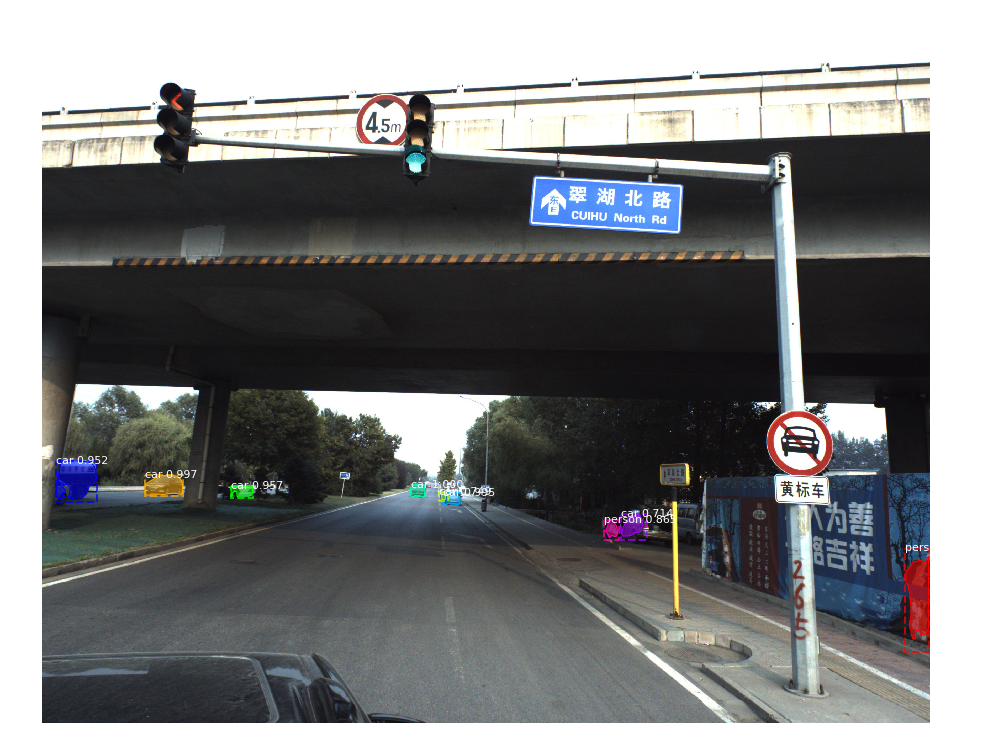

In [3]:
# Load a random image from the images folder
WAD_IM = "/home/stevenzc/cvpr-2018-autonomous-driving/test/92a65b9a2aeafe3a1a5ab1b21e32bbfe.jpg"
image = skimage.io.imread(WAD_IM)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [4]:
def rle(mask):
    """Produces the WAD challenge run-length encoding format from a binary mask.
    
    Inputs:
        mask - 2D numpy binary mask array
    
    Returns:
        rle_str - RLE string in WAD submission format, zero indexed, | delimited
    """
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    # find locations where the run length changes
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    pieces = []
    
    for left, right in zip(runs[::2], runs[1::2]):
        pieces.append(str(left) + ' ' + str(right) + '|')
    
    return ''.join(pieces)

    
sample_mask = np.array([[1, 0, 0],
                       [1, 1, 1],
                       [0, 1, 1]])

print(rle(sample_mask))
print(np.sum(sample_mask))

0 1|3 3|7 2|
6


In [5]:
# translate between our class ids (the keys) to wad class ids (the values)

ours_to_wad = {
    1: 33,
    2: 34,
    3: 35,
    4: 36,
    5: 38,
    6: 39,
    7: 40
}

#### Create the submission CSV

Creating the submission CSV took about 2 hours on a single K80 GPU.
Speed is about 3 seconds per image.

In [ ]:
import glob
import csv

# NOTE: change the home directory name here
WAD_TEST = "/home/stevenzc/cvpr-2018-autonomous-driving/test/"
filenames = glob.glob(os.path.join(WAD_TEST, '*.jpg'))


with open('submission.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    # write header row 
    writer.writerow(['ImageId', 'LabelId', 'PixelCount', 'Confidence', 'EncodedPixels'])
    
    rows = 1
    
    for i, f in enumerate(filenames):
        if i % 10 == 0:
            print('image: ' + str(i) + ', rows: ' + str(rows))
        image = skimage.io.imread(f)
        results = model.detect([image], verbose=0)

        r = results[0]
        class_ids = r['class_ids']
        scores = r['scores']
        masks = r['masks']
        N = len(class_ids)

        image_id = os.path.splitext(os.path.basename(f))[0]

        for n in range(N):
            our_id = class_ids[n]
            if our_id in ours_to_wad:
                # collect object instance information
                wad_id = ours_to_wad[our_id]
                pixel_count = np.sum(masks[:, :, n])
                confid = scores[n]
                rle_str = rle(masks[:, :, n])
                # write instance as row to output
                writer.writerow([image_id, wad_id, pixel_count, confid, rle_str])
                rows += 1

image: 0, rows: 1
image: 10, rows: 49
image: 20, rows: 156
image: 30, rows: 259
image: 40, rows: 340
image: 50, rows: 427
image: 60, rows: 542
image: 70, rows: 663
image: 80, rows: 785
image: 90, rows: 871
image: 100, rows: 980
image: 110, rows: 1066
image: 120, rows: 1159
image: 130, rows: 1274
image: 140, rows: 1393
image: 150, rows: 1475
image: 160, rows: 1573
image: 170, rows: 1702
image: 180, rows: 1778
image: 190, rows: 1871
image: 200, rows: 1970
image: 210, rows: 2106
image: 220, rows: 2221
image: 230, rows: 2321
image: 240, rows: 2450
image: 250, rows: 2565
image: 260, rows: 2689
image: 270, rows: 2805
image: 280, rows: 2971
image: 290, rows: 3074
image: 300, rows: 3189
image: 310, rows: 3295
image: 320, rows: 3388
image: 330, rows: 3479
image: 340, rows: 3631
image: 350, rows: 3719
image: 360, rows: 3848
image: 370, rows: 3952
image: 380, rows: 4019
image: 390, rows: 4099
image: 400, rows: 4205
image: 410, rows: 4317
image: 420, rows: 4455
image: 430, rows: 4567
image: 440, r